In [2]:
#!/usr/bin/python
import sys
sys.path.append("../tools/")
sys.path.append("../scripts/")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from helper import get_features, predict_from_score, correlate, crt_plot, plt_precision_recall_vs_threshold, plt_precision_vs_recall, plot_roc_curve, flex_classifier 

import pickle

from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, load_classifier_and_data, test_classifier

MODELS = '../classifiers/'
IMAGES = '../images/'
DATA   = '../data/'

----

In [3]:
#############################
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# features_list = ['poi','salary'] # You will need to use more features
payment_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'other', 'expenses', 'director_fees', 'total_payments']
stock_features   = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
mail_features    = ['from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']
extra_features   = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate',
                    'toPOI_rate', 'fromPOI_rate']
extra_finance    = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate']
extra_mail       = ['toPOI_rate', 'fromPOI_rate']
feature_list = payment_features + stock_features + mail_features + extra_features

In [4]:
feature_list

['salary',
 'bonus',
 'long_term_incentive',
 'deferred_income',
 'deferral_payments',
 'other',
 'expenses',
 'director_fees',
 'total_payments',
 'exercised_stock_options',
 'restricted_stock',
 'restricted_stock_deferred',
 'total_stock_value',
 'from_this_person_to_poi',
 'from_poi_to_this_person',
 'shared_receipt_with_poi',
 'bonus_deferral_payments_rate',
 'rest_stock_deferral_payments_rate',
 'exer_stock_options_deferral_payments_rate',
 'long_term_incentive_total_payments_rate',
 'bonus_total_payments_rate',
 'exer_stock_options_total_payments_rate',
 'toPOI_rate',
 'fromPOI_rate']

In [5]:
### Load the dictionary containing the dataset
my_data = pd.read_pickle(DATA+"my_dataFrame.pkl")
# Divide data into features and labels 
y = my_data['poi'].copy().astype(np.uint8)
X = my_data[feature_list].copy()
# Split data into training and test set using stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=77, stratify=y) 

----

In [6]:
# I spare 30% of the data as test set to have at least 5 'poi's in the test set. It's important to me to realize a high recall value, identifying as many 'poi's as possible.  
print "Number of POIs in the test set:" , y_test.sum()

Number of POIs in the test set: 6


In [7]:
# Save the order of insiders
insiders_train = y_train.index
insiders_test  = y_test.index

In [8]:
# Dealing with missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Imputation Stategies

In [9]:
# I'd like to explore different strategies filling NAN values
# Imputer_01:
# Applies median to mail and extra NAN features and 0 to financial NAN features
impute_01 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='median'), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')
# Imputer_02:
# Applies median to all NAN features 
impute_02 = SimpleImputer(strategy='median')
# Imputer_03:
# Applies 0.0 to all NAN features
impute_03 = SimpleImputer(strategy='constant', fill_value=0.0)
# Imputer 04
# Applies 0.0 to financial and extra_finance featurtes and median to 'mail_features' and 'extra_mail'
impute_04 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')
# Imputer 05
# Applies mean values to all NAN
impute_05 = SimpleImputer(strategy='mean')
imputers = [impute_01, impute_02, impute_03, impute_04, impute_05]

### Scaling strategies

In [10]:
def no_scaling(X):
    return np.array(X)

In [11]:
# Define different scaling strategies
#no_scl     = FunctionTransformer(func=lambda x: np.array(x))
no_scl     = FunctionTransformer(func=no_scaling)
robust_scl = RobustScaler()
std_scl    = StandardScaler()
power_scl  = PowerTransformer(method='yeo-johnson')
scalers = [no_scl, robust_scl, std_scl, power_scl]
scaler_names = ['NO SCALING', 'ROBUST SCALER', 'STANDARD SCALER', 'POWER SCALER']

----

### The most promising models

In [12]:
from sklearn.linear_model import SGDClassifier  

In [13]:
SGD_clf = SGDClassifier(random_state=77)

In [14]:
from sklearn import svm

In [15]:
svm_clf = svm.SVC(gamma='auto')

In [16]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

In [17]:
RF_clf = RandomForestClassifier(random_state=77, n_estimators=100, bootstrap=True)

In [18]:
classifiers = [ svm_clf, RF_clf, SGD_clf]

In [19]:
clf_names = [ 'SVC', 'Rand. Forest', 'SGD']

In [20]:
# Build pipelines for imputation and scaling
pipe_41 = Pipeline([ ('impute_04', impute_04), ('scale', no_scl) ])
pipe_44 = Pipeline([ ('impute_04', impute_04), ('scale', power_scl) ])

X_train_41 = pipe_41.fit_transform(X_train);
X_train_44 = pipe_44.fit_transform(X_train);

C:\Users\micha\Programs\anaconda3\envs\py27\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


----

## Feature selection

### Try different sets of features and check the impact on the results (ROC AUC)

In [21]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

In [22]:
svm_clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
y_scores = cross_val_predict(svm_clf, X_train_44, y_train, cv=10, method='decision_function' )

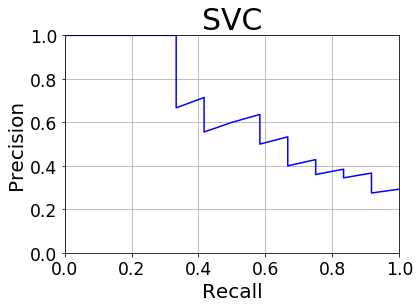

In [24]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC')

In [25]:
y_pred = predict_from_score(y_train, y_scores, 0.9, 0.3, verbose=1)

Realized metric values:
Recall: 0.9166666666666666
Precision: 0.36666666666666664
Probability/ decision function: -0.9314159592340644
Index: 11


In [26]:
confusion_matrix(y_train, y_pred)

array([[69, 19],
       [ 1, 11]], dtype=int64)

In [27]:
roc_auc_score(y_train, y_scores)

0.9119318181818181

In [28]:
X_train_44_df = pd.DataFrame(X_train_44, columns=feature_list)

In [29]:
y_scores = cross_val_predict(svm_clf, X_train_44_df.loc[:, payment_features+stock_features+extra_mail], y_train, cv=10, method='decision_function' )

In [30]:
roc_auc_score(y_train, y_scores)

0.9422348484848485

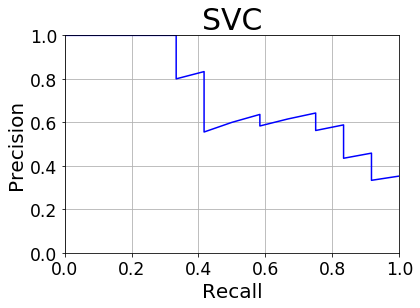

In [31]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC')

----

#### Feature reduction

##### Variance Threshold

In [32]:
from sklearn.feature_selection import VarianceThreshold

In [33]:
varianceThreshold = VarianceThreshold()

In [34]:
varianceThreshold.fit(X_train_44)

VarianceThreshold(threshold=0.0)

In [35]:
varianceThreshold.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [36]:
varianceThreshold.variances_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [37]:
# Seems that all features are important

##### SelectKBest and SelectPercentile

In [38]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, SelectFdr, SelectFpr
KBest = SelectKBest(k=24 )
X_train_44_red = KBest.fit_transform(X_train_44, y_train)
# KBest.fit_transform(X_train_44, y_train)
KBest_scores_df = pd.DataFrame(KBest.scores_, index=feature_list)
KBest_scores_df.sort_values(0, ascending=False)

,0
toPOI_rate,16.262856
total_stock_value,14.241934
bonus_total_payments_rate,11.526630
expenses,10.429717
bonus,10.375911
other,10.141966
long_term_incentive,8.855082
total_payments,8.432336
restricted_stock,7.226538
salary,7.109366


In [39]:
KBest.scores_

array([7.10936645e+00, 1.03759105e+01, 8.85508210e+00, 3.63167252e+00,
       4.01502261e-02, 1.01419659e+01, 1.04297173e+01, 1.68000000e+00,
       8.43233622e+00, 1.49203552e+00, 7.22653784e+00, 2.03839970e+00,
       1.42419337e+01, 5.48745807e+00, 3.83145556e+00, 6.65337629e+00,
       2.49616349e-02, 1.84837049e-03, 2.27228095e-01, 6.68634505e+00,
       1.15266301e+01, 1.75033237e+00, 1.62628562e+01, 5.53620231e-01])

In [40]:
y_scores = cross_val_predict(svm_clf, X_train_44_red, y_train, cv=10, method='decision_function' )

In [41]:
roc_auc_score(y_train, y_scores)

0.9119318181818181

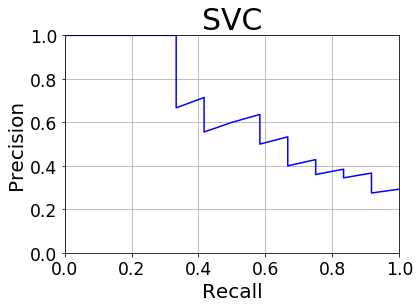

In [42]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC')

In [43]:
feature_list = payment_features + stock_features + mail_features + extra_features

In [44]:
for n in range(1, len(feature_list)+1):
    KBest = SelectKBest(k=n)
    X_train_44_red = KBest.fit_transform(X_train_44, y_train)
    y_scores = cross_val_predict(svm_clf, X_train_44_red, y_train, cv=6, method='decision_function')
    print roc_auc_score(y_train, y_scores), "ROC AUC for", n, "features."

0.5913825757575757 ROC AUC for 1 features.
0.5293560606060606 ROC AUC for 2 features.
0.7357954545454546 ROC AUC for 3 features.
0.8134469696969696 ROC AUC for 4 features.
0.8409090909090908 ROC AUC for 5 features.
0.872159090909091 ROC AUC for 6 features.
0.834280303030303 ROC AUC for 7 features.
0.8314393939393939 ROC AUC for 8 features.
0.8418560606060606 ROC AUC for 9 features.
0.8456439393939393 ROC AUC for 10 features.
0.7755681818181818 ROC AUC for 11 features.
0.8295454545454545 ROC AUC for 12 features.
0.8200757575757576 ROC AUC for 13 features.
0.8314393939393939 ROC AUC for 14 features.
0.8323863636363636 ROC AUC for 15 features.
0.837121212121212 ROC AUC for 16 features.
0.8645833333333333 ROC AUC for 17 features.
0.8598484848484848 ROC AUC for 18 features.
0.8844696969696969 ROC AUC for 19 features.
0.8731060606060607 ROC AUC for 20 features.
0.8882575757575757 ROC AUC for 21 features.
0.896780303030303 ROC AUC for 22 features.
0.8816287878787878 ROC AUC for 23 features.
0

##### RFE and RFECV

In [45]:
from sklearn.feature_selection import RFE, RFECV

In [46]:
SVC_lin = svm.SVC(gamma='auto', kernel='linear')

In [47]:
RFE_ = RFE(SVC_lin).fit(X_train_44, y_train)

In [48]:
RFE_.ranking_

array([ 1,  1,  6,  1,  3,  2,  1, 13,  9,  1, 10,  5,  1,  8, 11,  1,  1,
        1,  1,  4,  7,  1,  1, 12])

In [49]:
RFE_.get_support()

array([ True,  True, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True,  True,  True,
        True, False, False,  True,  True, False])

In [50]:
y_scores = cross_val_predict(svm_clf, X_train_44[:,RFE_.get_support()], y_train, cv=10, method='decision_function' )

In [51]:
roc_auc_score(y_train, y_scores)

0.9412878787878789

In [52]:
for n in range(1, len(feature_list)+1):
    X_train_44_red = RFE(SVC_lin, n_features_to_select=n).fit_transform(X_train_44, y_train)
    y_scores = cross_val_predict(SVC_lin, X_train_44_red, y_train, cv=6, method='decision_function')
    print roc_auc_score(y_train, y_scores), "ROC AUC for", n, "features."

0.33333333333333337 ROC AUC for 1 features.
0.6846590909090908 ROC AUC for 2 features.
0.7954545454545454 ROC AUC for 3 features.
0.9375000000000001 ROC AUC for 4 features.
0.9214015151515151 ROC AUC for 5 features.
0.9289772727272727 ROC AUC for 6 features.
0.928030303030303 ROC AUC for 7 features.
0.9346590909090909 ROC AUC for 8 features.
0.9261363636363636 ROC AUC for 9 features.
0.9441287878787878 ROC AUC for 10 features.
0.9261363636363636 ROC AUC for 11 features.
0.9214015151515151 ROC AUC for 12 features.
0.918560606060606 ROC AUC for 13 features.
0.9109848484848484 ROC AUC for 14 features.
0.9185606060606061 ROC AUC for 15 features.
0.9109848484848484 ROC AUC for 16 features.
0.9119318181818181 ROC AUC for 17 features.
0.9138257575757576 ROC AUC for 18 features.
0.9043560606060606 ROC AUC for 19 features.
0.8996212121212122 ROC AUC for 20 features.
0.8778409090909092 ROC AUC for 21 features.
0.8740530303030303 ROC AUC for 22 features.
0.8740530303030303 ROC AUC for 23 features

0.9441287878787878 ROC AUC for


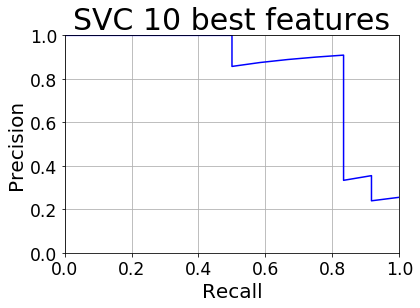

In [53]:
# Plot precision vs recall curve for 10 best features leading to highest ROC
RFE_10 = RFE(SVC_lin, n_features_to_select=10).fit(X_train_44, y_train)
X_train_44_ = RFE_10.transform(X_train_44)
y_scores = cross_val_predict(SVC_lin, X_train_44_, y_train, cv=6, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC 10 best features', save=IMAGES+"RFE_precision_vs_recall.png")

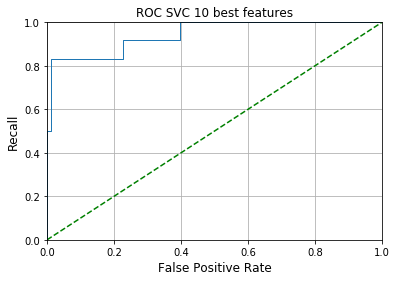

In [54]:
fpr, tpr, thresh = roc_curve(y_train, y_scores)
plot_roc_curve(fpr, tpr, title='ROC SVC 10 best features')

In [55]:
RFE_1 = RFE(SVC_lin, n_features_to_select=1).fit(X_train_44, y_train)
score_table = pd.DataFrame(zip(X_train_44_df.columns.to_list(), RFE_1.ranking_))
print RFE_1.ranking_
score_table.sort_values(1, ascending=True)

[11  5 17  9 14 13  1 24 20  3 21 16  2 19 22 10  8  7  6 15 18 12  4 23]


,0,1
6,expenses,1
12,total_stock_value,2
9,exercised_stock_options,3
22,toPOI_rate,4
1,bonus,5
18,exer_stock_options_deferral_payments_rate,6
17,rest_stock_deferral_payments_rate,7
16,bonus_deferral_payments_rate,8
3,deferred_income,9
15,shared_receipt_with_poi,10


In [56]:
RFECV_recall = RFECV(SVC_lin, cv=6, min_features_to_select=5, scoring='recall').fit(X_train_44,y_train)

In [57]:
RFECV_recall.n_features_

10

In [58]:
RFECV_recall.ranking_

array([ 2,  1,  8,  1,  5,  4,  1, 15, 11,  1, 12,  7,  1, 10, 13,  1,  1,
        1,  1,  6,  9,  3,  1, 14])

In [59]:
# ROC AUC scoring for ranking of features
RFECV_ = RFECV(SVC_lin, cv=6, min_features_to_select=1, scoring='roc_auc').fit(X_train_44,y_train)

In [60]:
RFECV_.n_features_

10

In [61]:
RFECV_.ranking_

array([ 2,  1,  8,  1,  5,  4,  1, 15, 11,  1, 12,  7,  1, 10, 13,  1,  1,
        1,  1,  6,  9,  3,  1, 14])

In [62]:
RFECV_.support_

array([False,  True, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True,  True,  True,
        True, False, False, False,  True, False])

In [63]:
RFECV_.grid_scores_

array([0.37619048, 0.80238095, 0.83492063, 0.8952381 , 0.89563492,
       0.87857143, 0.87857143, 0.89047619, 0.89603175, 0.91904762,
       0.91865079, 0.91865079, 0.91865079, 0.91269841, 0.91269841,
       0.90714286, 0.90119048, 0.90119048, 0.90674603, 0.90674603,
       0.90674603, 0.90674603, 0.90674603, 0.90674603])

0.9185606060606061 ROC AUC for


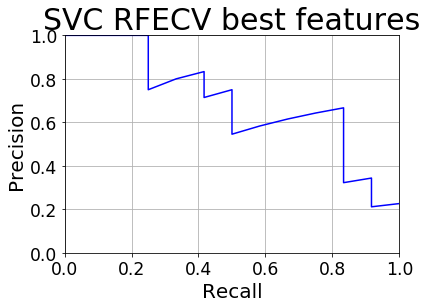

In [64]:
# RFECV features reduction. RFB Kernel results.
y_scores = cross_val_predict(svm_clf, X_train_44[:,RFECV_.support_], y_train, cv=6, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC RFECV best features')

In [65]:
score_table = pd.DataFrame(zip(feature_list, RFECV_.ranking_))
score_table.sort_values(1, axis='index')

,0,1
1,bonus,1
3,deferred_income,1
6,expenses,1
18,exer_stock_options_deferral_payments_rate,1
9,exercised_stock_options,1
17,rest_stock_deferral_payments_rate,1
22,toPOI_rate,1
12,total_stock_value,1
16,bonus_deferral_payments_rate,1
15,shared_receipt_with_poi,1


0.9441287878787878 ROC AUC for


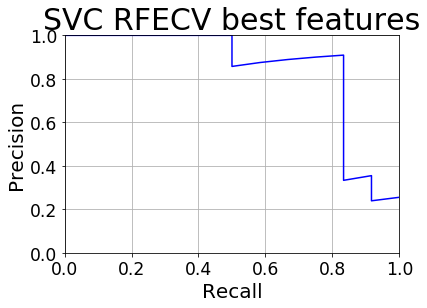

In [66]:
# RFECV features reduction. Linear Model results.
y_scores = cross_val_predict(SVC_lin, X_train_44[:,RFECV_.support_], y_train, cv=6, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC RFECV best features')

#### PCA

In [67]:
from sklearn.decomposition import PCA 

In [68]:
for n in range(1, len(feature_list)+1):
    X_train_44_red = PCA(n_components=n).fit_transform(X_train_44)
    y_scores = cross_val_predict(svm_clf, X_train_44_red, y_train, cv=6, method='decision_function')
    print roc_auc_score(y_train, y_scores), "ROC AUC for", n, "features."

0.5009469696969697 ROC AUC for 1 features.
0.6903409090909092 ROC AUC for 2 features.
0.6818181818181819 ROC AUC for 3 features.
0.8191287878787878 ROC AUC for 4 features.
0.7253787878787878 ROC AUC for 5 features.
0.7556818181818181 ROC AUC for 6 features.
0.821969696969697 ROC AUC for 7 features.
0.8910984848484849 ROC AUC for 8 features.
0.8873106060606061 ROC AUC for 9 features.
0.8749999999999999 ROC AUC for 10 features.
0.8797348484848484 ROC AUC for 11 features.
0.8797348484848485 ROC AUC for 12 features.
0.893939393939394 ROC AUC for 13 features.
0.8863636363636364 ROC AUC for 14 features.
0.8816287878787878 ROC AUC for 15 features.
0.8835227272727273 ROC AUC for 16 features.
0.8910984848484849 ROC AUC for 17 features.
0.8929924242424242 ROC AUC for 18 features.
0.8892045454545454 ROC AUC for 19 features.
0.884469696969697 ROC AUC for 20 features.
0.8806818181818182 ROC AUC for 21 features.
0.8787878787878787 ROC AUC for 22 features.
0.8768939393939394 ROC AUC for 23 features.


In [69]:
pca_ = PCA(n_components=.99).fit(X_train_44)

In [70]:
pca_.explained_variance_ratio_

array([0.31895517, 0.15379203, 0.09814145, 0.07858794, 0.05246774,
       0.04941141, 0.0448794 , 0.04059978, 0.03483559, 0.02529364,
       0.02243168, 0.01633678, 0.01504247, 0.00957238, 0.00948377,
       0.00804576, 0.00569706, 0.00549994, 0.00322706])

0.9128787878787878 ROC AUC for


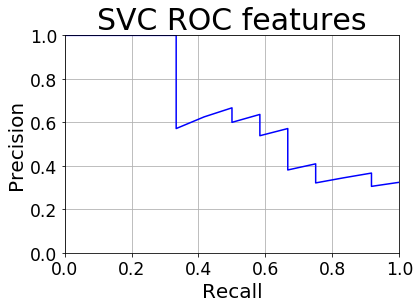

In [71]:
X_train_44_red = PCA(n_components=.99).fit_transform(X_train_44)
y_scores = cross_val_predict(svm_clf, X_train_44_red, y_train, cv=10, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC ROC features')

No that good as RFECV!

#### Grid search and Randomized search of Hyperparameters

In [72]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Model to be investigated
clf = svm.SVC()

In [73]:
pipe = Pipeline([
    ('impute', impute_04),
    ('scale', power_scl),
    ('feature_red', RFECV(SVC_lin, cv=6, scoring='roc_auc', min_features_to_select=5)),
    ('clf', clf)
])

In [74]:
param_grid = [
    {
        #'feature_red__min_features_to_select': range(5,16),
        'clf__kernel': ['rbf', 'linear'],
        'clf__gamma': np.linspace(0.0, 0.1, 20),
        'clf__C': [10, 100, 1000, 10000, 100000]
    }
]

In [75]:
gridSch = GridSearchCV(pipe, param_grid=param_grid, return_train_score=True, cv=6, scoring='roc_auc', verbose=1, refit=True, n_jobs=8, iid=False)

In [76]:
gridSch.fit(X_train, y_train);

Fitting 6 folds for each of 200 candidates, totalling 1200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   19.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   31.2s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:   46.2s finished


In [77]:
gridSch.best_params_

{'clf__C': 100, 'clf__gamma': 0.010526315789473684, 'clf__kernel': 'rbf'}

In [78]:
gridSch.best_estimator_.named_steps.feature_red.ranking_

array([ 2,  1,  8,  1,  5,  4,  1, 15, 11,  1, 12,  7,  1, 10, 13,  1,  1,
        1,  1,  6,  9,  3,  1, 14])

In [79]:
gridSch.best_estimator_.named_steps.feature_red.ranking_ <= 6

array([ True,  True, False,  True,  True,  True,  True, False, False,
        True, False, False,  True, False, False,  True,  True,  True,
        True,  True, False,  True,  True, False])

In [80]:
X_train_44_red = X_train_44[:, gridSch.best_estimator_.named_steps.feature_red.ranking_ <= 8]

In [81]:
gridSch.best_score_

0.9119047619047619

In [82]:
# Random search to find best set of features

In [83]:
param_distributions = {
            'kernel': ['linear', 'rbf'],
            'C': stats.reciprocal(0.1, 10000),
            'gamma': stats.expon(scale=1.0),
            #'degree': [3, 5, 7, 10]
        }

In [84]:
RandSearch = RandomizedSearchCV(clf, param_distributions, cv=6, n_iter=5000, scoring='roc_auc', iid=False, verbose=1, n_jobs=8, random_state=77)

In [85]:
# Interate over number of features
n_select = (RFECV_.ranking_ == 1).sum()
n_select

10

In [86]:
''' Uncomment to run
n_select = (RFECV_.ranking_ == 1).sum()
for n in range(1, 11):
    X = X_train_44[:, RFECV_.ranking_ <= n]
    RandSearch.fit(X, y_train)
    print "Number of features:", (n_select + n - 1)
    print "Best models score:", RandSearch.best_score_
    print "Best params:", RandSearch.best_params_
'''

' Uncomment to run\nn_select = (RFECV_.ranking_ == 1).sum()\nfor n in range(1, 11):\n    X = X_train_44[:, RFECV_.ranking_ <= n]\n    RandSearch.fit(X, y_train)\n    print "Number of features:", (n_select + n - 1)\n    print "Best models score:", RandSearch.best_score_\n    print "Best params:", RandSearch.best_params_\n'

### Check poly kernel

In [87]:
poly_SVC = svm.SVC()

In [88]:
param_distributions_2 = {
            'kernel': ['poly'],
            'degree': np.arange(3,11),
            'coef0': stats.uniform(scale=10)
        }

In [89]:
RandSearch_poly = RandomizedSearchCV(poly_SVC, param_distributions_2, cv=6, n_iter=5000, scoring='recall', iid=False, verbose=1, n_jobs=8, random_state=77)

In [90]:
RandSearch_poly.fit(X_train_44_red, y_train)

Fitting 6 folds for each of 5000 candidates, totalling 30000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 268 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 3502 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 10502 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 20302 tasks      | elapsed:   17.3s
[Parallel(n_jobs=8)]: Done 30000 out of 30000 | elapsed:   25.5s finished


RandomizedSearchCV(cv=6, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=False, n_iter=5000, n_jobs=8,
          param_distributions={'kernel': ['poly'], 'coef0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000E0C73C8>, 'degree': array([ 3,  4,  5,  6,  7,  8,  9, 10])},
          pre_dispatch='2*n_jobs', random_state=77, refit=True,
          return_train_score='warn', scoring='recall', verbose=1)

In [91]:
RandSearch_poly.best_score_

0.6666666666666666

In [92]:
RandSearch_poly.best_params_

{'coef0': 3.8570365811560636, 'degree': 3, 'kernel': 'poly'}

----

Find best parameters for SVC model usinf Randomized Search algorithm

In [93]:
clf = svm.SVC()

In [94]:
X_train_44_red10 = pipe_44.transform(X_train)[:, RFECV_.ranking_ <= 1]
X_test_44_red10 = pipe_44.transform(X_test)[:, RFECV_.ranking_ <= 1]

In [95]:
param_distributions = {
            'kernel': ['linear', 'rbf'],
            #'C': stats.reciprocal(0.1, 10000),
            #'C': stats.uniform(0.1, 10000),
            'C': stats.halfnorm(0.1, 10000),
            'gamma': stats.expon(scale=1.0),
        }

In [96]:
RandSearch = RandomizedSearchCV(clf, param_distributions, cv=6, n_iter=5000, scoring='roc_auc', iid=False, verbose=1, n_jobs=8, random_state=77)

In [97]:
RandSearch.fit(X_train_44_red10, y_train)

Fitting 6 folds for each of 5000 candidates, totalling 30000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 232 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 3556 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 9556 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 17956 tasks      | elapsed:   16.7s
[Parallel(n_jobs=8)]: Done 28756 tasks      | elapsed:   26.5s
[Parallel(n_jobs=8)]: Done 30000 out of 30000 | elapsed:   27.4s finished


RandomizedSearchCV(cv=6, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=False, n_iter=5000, n_jobs=8,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000CB40D48>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000DCAA708>},
          pre_dispatch='2*n_jobs', random_state=77, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=1)

In [98]:
RandSearch.best_score_

0.9702380952380952

In [99]:
RandSearch.best_params_

{'C': 1143.112516422697, 'gamma': 0.0011361715382653187, 'kernel': 'rbf'}

In [100]:
# Make predictions on test set

0.9564393939393939 ROC AUC for


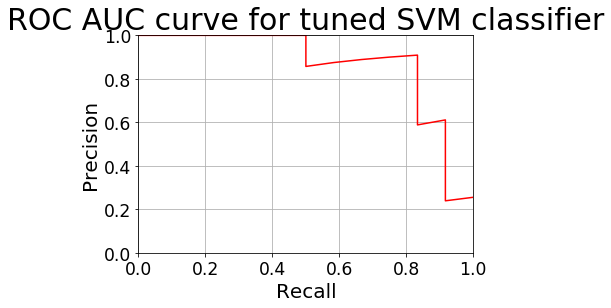

In [101]:
y_scores = cross_val_predict(RandSearch.best_estimator_, X_train_44_red10, y_train, cv=6, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
#plt_precision_vs_recall(precision, recall, title='SVC ROC features')
plt_precision_vs_recall(precision, recall, title='ROC AUC curve for tuned SVM classifier', color='red')

In [102]:
clf = RandSearch.best_estimator_

In [103]:
clf.fit(X_train_44_red10, y_train)

SVC(C=1143.112516422697, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0011361715382653187,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

0.8026315789473684 ROC AUC for


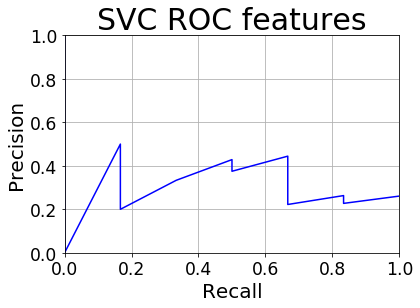

In [104]:
y_scores = clf.decision_function(X_test_44_red10)
print roc_auc_score(y_test, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_test, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC ROC features')

In [105]:
feature_list = payment_features + stock_features + mail_features + extra_features
selected_features = get_features(feature_list,  RFECV_.ranking_ <= 1)

In [106]:
# Features
X_train_44_red10_df = pd.DataFrame(X_train_44_red10, columns=selected_features, index=insiders_train)
X_test_44_red10_df = pd.DataFrame(X_test_44_red10, columns=selected_features, index=insiders_test)
X_44_df = X_train_44_red10_df.append(X_test_44_red10_df, sort=False)

# Labels
y_df = y_train.append(y_test)

# Combine features and labels
my_dataset = X_44_df.copy()
my_dataset.insert(0, column='poi', value=y_df)

# Create dataset dict for validation
my_dataset_dict = my_dataset.transpose().to_dict() 

In [107]:
# Dump data
dump_classifier_and_data(clf, my_dataset_dict, ['poi'] + selected_features)

----

### Validate model

In [108]:
clf, dataset, feature_list = load_classifier_and_data()

In [109]:
test_classifier(clf, dataset, feature_list)

SVC(C=1143.112516422697, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0011361715382653187,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
	Accuracy: 0.88667	Precision: 0.60933	Recall: 0.41800	F1: 0.49585	F2: 0.44601
	Total predictions: 15000	True positives:  836	False positives:  536	False negatives: 1164	True negatives: 12464



----

### Check SVC model using 'recall' scoring metric
Determine number of relevant features using 'recall' scoring

In [110]:
clf = svm.SVC()

In [111]:
param_distributions

{'C': <scipy.stats._distn_infrastructure.rv_frozen at 0xcb40d48>,
 'gamma': <scipy.stats._distn_infrastructure.rv_frozen at 0xdcaa708>,
 'kernel': ['linear', 'rbf']}

In [112]:
RandSearch_recall = RandomizedSearchCV(clf, param_distributions, cv=6, n_iter=5000, scoring='recall', iid=False, verbose=1, n_jobs=8, random_state=77)

In [113]:
''' Comment added as this snipped takes some time
n_select = (RFECV_.ranking_ == 1).sum()
for n in range(1, 11):
    X = X_train_44[:, RFECV_.ranking_ <= n]
    RandSearch_recall.fit(X, y_train)
    print "Number of features:", (n_select + n - 1)
    print "Best models score:", RandSearch_recall.best_score_
    print "Best params:", RandSearch_recall.best_params_
'''

' Comment added as this snipped takes some time\nn_select = (RFECV_.ranking_ == 1).sum()\nfor n in range(1, 11):\n    X = X_train_44[:, RFECV_.ranking_ <= n]\n    RandSearch_recall.fit(X, y_train)\n    print "Number of features:", (n_select + n - 1)\n    print "Best models score:", RandSearch_recall.best_score_\n    print "Best params:", RandSearch_recall.best_params_\n'

In [114]:
RandSearch = RandomizedSearchCV(clf, param_distributions, cv=6, n_iter=5000, scoring='recall', iid=False, verbose=1, n_jobs=8, random_state=77)

In [115]:
RandSearch.fit(X_train_44_red10, y_train)

Fitting 6 folds for each of 5000 candidates, totalling 30000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 340 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 3040 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 7540 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 13840 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 21940 tasks      | elapsed:   19.8s
[Parallel(n_jobs=8)]: Done 30000 out of 30000 | elapsed:   26.8s finished


RandomizedSearchCV(cv=6, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=False, n_iter=5000, n_jobs=8,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000CB40D48>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000DCAA708>},
          pre_dispatch='2*n_jobs', random_state=77, refit=True,
          return_train_score='warn', scoring='recall', verbose=1)

In [116]:
RandSearch.best_score_

0.8333333333333334

In [117]:
RandSearch.best_params_

{'C': 5204.545052836362, 'gamma': 0.0031819765309934927, 'kernel': 'rbf'}

In [118]:
clf = RandSearch.best_estimator_

In [119]:
feature_list = payment_features + stock_features + mail_features + extra_features
selected_features = get_features(feature_list,  RFECV_.ranking_ <= 1)

In [120]:
# Features
X_train_44_red10_df = pd.DataFrame(X_train_44_red10, columns=selected_features, index=insiders_train)
X_test_44_red10_df = pd.DataFrame(X_test_44_red10, columns=selected_features, index=insiders_test)
X_44_df = X_train_44_red10_df.append(X_test_44_red10_df, sort=False)

# Labels
y_df = y_train.append(y_test)

# Combine features and labels
my_dataset = X_44_df.copy()
my_dataset.insert(0, column='poi', value=y_df)

# Create dataset dict for validation
my_dataset_dict = my_dataset.transpose().to_dict() 

In [121]:
# Dump data
dump_classifier_and_data(clf, my_dataset_dict, ['poi'] + selected_features)

----

### Validate model

In [122]:
clf, dataset, feature_list = load_classifier_and_data()

In [123]:
test_classifier(clf, dataset, feature_list)

SVC(C=5204.545052836362, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0031819765309934927,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
	Accuracy: 0.86240	Precision: 0.48180	Recall: 0.42350	F1: 0.45077	F2: 0.43400
	Total predictions: 15000	True positives:  847	False positives:  911	False negatives: 1153	True negatives: 12089



----

### Address precision/ recall trade-off

In [124]:
my_clf = flex_classifier(RandSearch.best_estimator_, min_precision=0.35, min_recall=0.4, maximize='recall')

In [125]:
my_clf.fit(X_train_44_red10, y_train)

flex_classifier(classifier=SVC(C=5204.545052836362, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0031819765309934927,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
        maximize='recall', min_precision=0.35, min_recall=0.4,
        threshold=0.0)

#### Determine best threshold

In [126]:
from sklearn.model_selection import StratifiedShuffleSplit

In [127]:
cv = StratifiedShuffleSplit(n_splits=14, random_state=77, test_size=0.35)

In [128]:
thresholds = []
for train_idx, test_idx in cv.split(X_train_44_red10, y_train):
    X_train_ = X_train_44_red10[train_idx]
    X_test_  = X_train_44_red10[test_idx]
    y_train_ = y_train[train_idx]
    y_test_  = y_train[test_idx]
    thresholds.append( list(my_clf.det_threshold(X_train_, y_train_, replace=False)))

In [129]:
thresholds = np.array(thresholds)
best_threshold = thresholds[:,0].mean(axis=0)
best_threshold

-0.8272396074523954

In [130]:
my_clf.threshold = best_threshold

### Validate model

#### Check model on test data

0.8026315789473684 ROC AUC


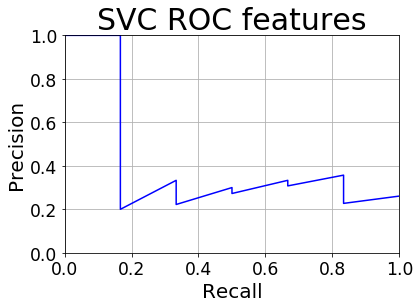

In [131]:
y_scores = my_clf.classifier.decision_function(X_test_44_red10)
print roc_auc_score(y_test, y_scores), "ROC AUC"
precision, recall, proba = precision_recall_curve(y_test, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC ROC features')

In [132]:
y_predict = my_clf.predict(X_test_44_red10)
print confusion_matrix(y_test, y_predict)

[[31  7]
 [ 4  2]]


In [133]:
recall_score(y_test, y_predict)

0.3333333333333333

In [134]:
precision_score(y_test, y_predict)

0.2222222222222222

----

In [135]:
# Dump data
dump_classifier_and_data(my_clf, my_dataset_dict, ['poi'] + selected_features)

----

#### Validate model using tester.py

In [136]:
clf, dataset, feature_list = load_classifier_and_data()

In [137]:
test_classifier(clf, dataset, feature_list)

flex_classifier(classifier=SVC(C=5204.545052836362, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0031819765309934927,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
        maximize='recall', min_precision=0.35, min_recall=0.4,
        threshold=-0.8272396074523954)
	Accuracy: 0.77873	Precision: 0.35716	Recall: 0.82450	F1: 0.49841	F2: 0.65348
	Total predictions: 15000	True positives: 1649	False positives: 2968	False negatives:  351	True negatives: 10032



In [138]:
feature_list

['poi',
 'bonus',
 'deferred_income',
 'expenses',
 'exercised_stock_options',
 'total_stock_value',
 'shared_receipt_with_poi',
 'bonus_deferral_payments_rate',
 'rest_stock_deferral_payments_rate',
 'exer_stock_options_deferral_payments_rate',
 'toPOI_rate']

----

### Save SVC model

In [139]:
with open(MODELS + "SVC_model.pkl", "w") as out:
    pickle.dump(my_clf, out)

In [140]:
with open(MODELS + "SVC_features.pkl", "w") as out:
    pickle.dump(my_dataset_dict, out)

In [141]:
with open(MODELS + "SVC_feature_list.pkl", "w") as out:
    pickle.dump(['poi'] + selected_features, out)